# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import qnm
from gwpy.timeseries import TimeSeries
import copy
from scipy.special import logsumexp
import astropy.constants as c

## Data

In [3]:
theoretical_values = [50, 0.69]

In [4]:
omega, A, C = qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=theoretical_values[1])
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [35]:
srate = 4096
t_range_prepad = np.linspace(0,0.5, int(srate/2), endpoint = False)
heaviside = np.heaviside(t_range_prepad, 1)
temp = 1e-22*np.exp(-1j*omega*t_range_prepad/(theoretical_values[0]*T_MSUN))
signal_prepad = np.real(temp*heaviside)
t_range = np.linspace(0,1, srate, endpoint = False)
signal = np.pad(signal_prepad, (int(srate/4),int(srate/4)))
noise = 1e-23*np.random.normal(size = srate)

(0.245, 0.265)

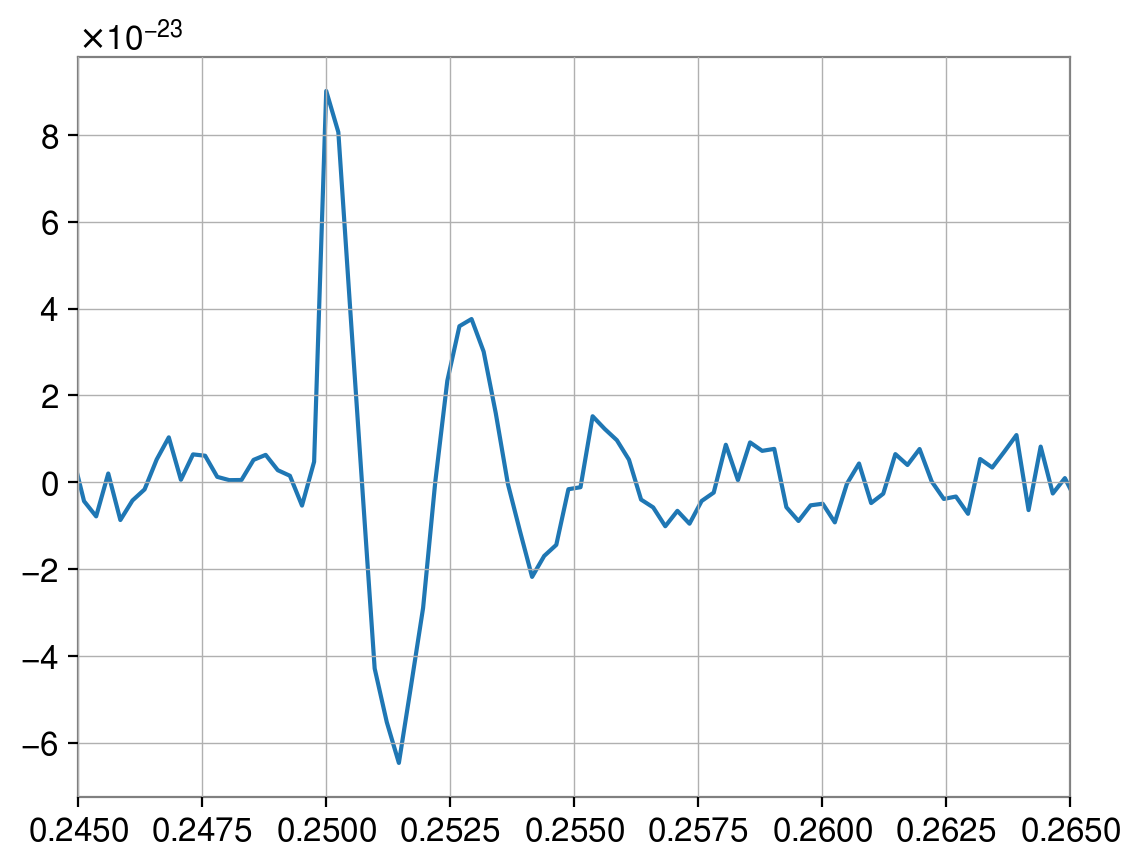

In [36]:
data = signal + .5*noise
pl.plot(t_range, data)
pl.xlim(0.245, 0.265)

## Filter

In [26]:
mass = qnm_filter.Filter.mass_unit(50)

In [27]:
input = dict(model_list = [(2,2,0, 'p')], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 0.25+3*mass, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [28]:
fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
fit.detector_alignment()
fit.condition_data('original_data', **input, trim = 0.0)
fit.compute_acfs('original_data')
fit.cholesky_decomposition()
fit.first_index()

In [29]:
fit_temp = qnm_filter.Network(**input)
fit_temp.original_data['H1'] = qnm_filter.RealData(signal, index = t_range)
fit_temp.detector_alignment()
fit_temp.condition_data('original_data', **input, trim = 0.0)
fit_temp.compute_acfs('original_data')
fit_temp.cholesky_decomposition()
fit_temp.first_index()
data = fit.truncate_data(fit.original_data)['H1']
template = fit_temp.truncate_data(fit_temp.original_data)['H1']

<AxesSubplot: >

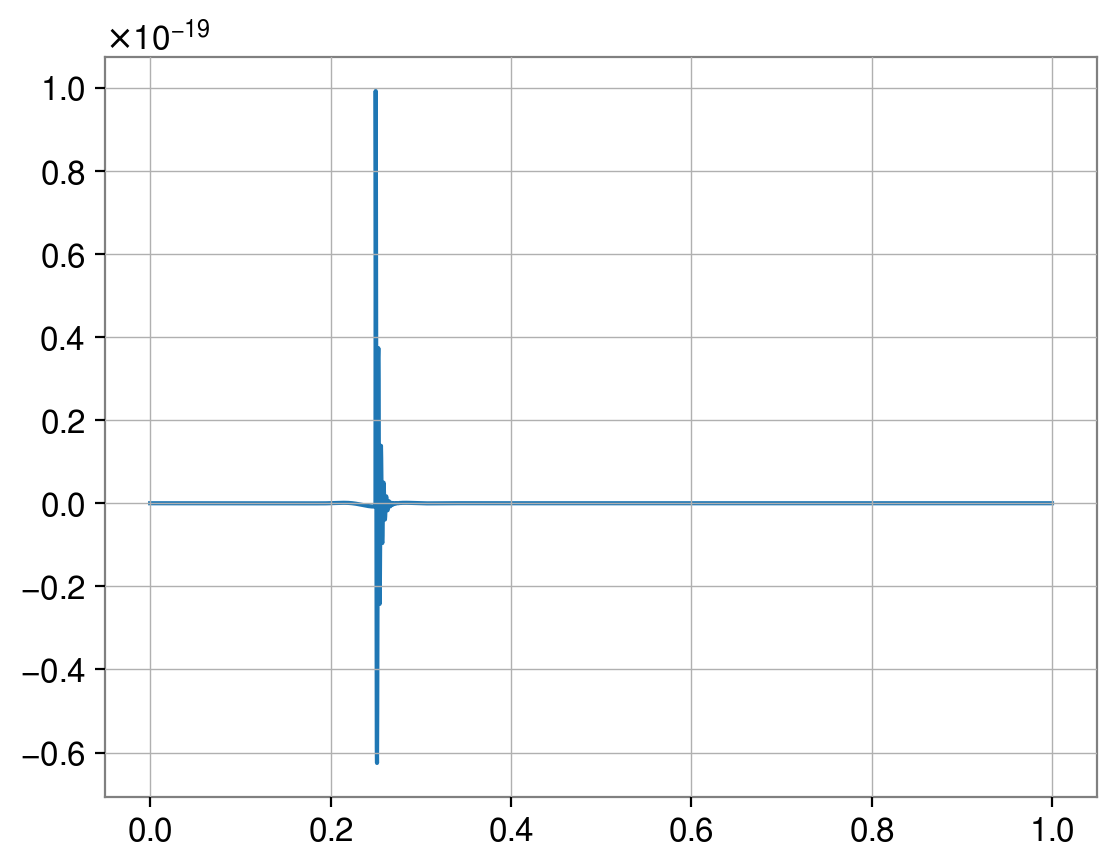

In [34]:
fit_temp.original_data['H1'].plot()

In [31]:
fit.compute_SNR(data, template, 'H1', optimal=True)

35.96575103808426

In [92]:
snr_points = 30
realisation_number = 50
scaling_arr = np.logspace(-1, 0.3, snr_points)
realisation_SNR = []
realisation_bayes = []

for i in range(realisation_number):
    noise = 1e-23*np.random.normal(size = srate)
    SNR_arr = []
    bayes_arr = []
    for j in scaling_arr:
        data = signal + j*noise

        fit = qnm_filter.Network(**input)
        fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)
        fit.detector_alignment()
        fit.condition_data('original_data', **input, trim = 0.0)
        fit.compute_acfs('original_data')
        fit.cholesky_decomposition()
        fit.first_index()

        fit_temp = qnm_filter.Network(**input)
        fit_temp.original_data['H1'] = qnm_filter.RealData(signal, index = t_range)
        fit_temp.detector_alignment()
        fit_temp.condition_data('original_data', **input, trim = 0.0)
        fit_temp.compute_acfs('original_data')
        fit_temp.cholesky_decomposition()
        fit_temp.first_index()
        data = fit.truncate_data(fit.original_data)['H1']
        template = fit_temp.truncate_data(fit_temp.original_data)['H1']

        SNR = fit.compute_SNR(data, template, 'H1', optimal=False)
        fit.compute_likelihood(apply_filter = False)
        fit.add_filter(mass = 50, chi = 0.5, model_list = [(2,2,0,'p')])
        Bayes = fit.compute_likelihood() - fit.compute_likelihood(apply_filter=False)

        bayes_arr.append(Bayes)
        SNR_arr.append(SNR)
    realisation_SNR.append(SNR_arr)
    realisation_bayes.append(bayes_arr)

In [93]:
realisation_bayes = np.log10(realisation_bayes)
realisation_snr = np.log10(realisation_SNR)

In [94]:
med_snr = np.array([np.median([realisation_snr[i,j] for i in range(realisation_number)]) for j in range(snr_points)])
med_bayes = np.array([np.median([realisation_bayes[i,j] for i in range(realisation_number)]) for j in range(snr_points)])
std_bayes = np.array([np.std([realisation_bayes[i,j] for i in range(realisation_number)]) for j in range(snr_points)])

Text(1.25, 1.25, 'Slope = 1.999 $\\pm$ 0.003')

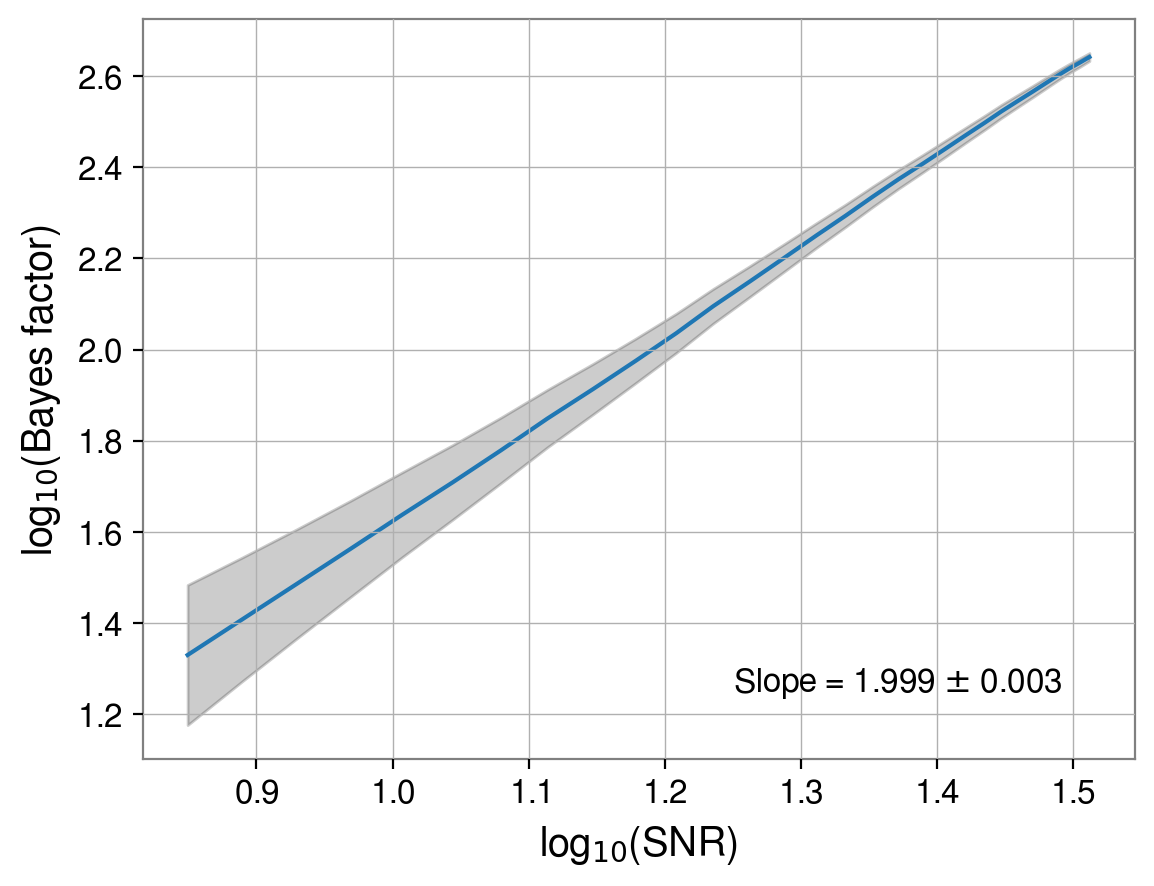

In [103]:
pl.plot(med_snr, med_bayes)
pl.fill_between(med_snr, 
                med_bayes-std_bayes, med_bayes+std_bayes,
               alpha = 0.2, color = 'k')
pl.xlabel("log$_{10}$(SNR)")
pl.ylabel("log$_{10}$(Bayes factor)")
pl.text(1.25, 1.25, 'Slope = 1.999 $\pm$ 0.003')

In [97]:
np.polyfit(med_snr, med_bayes, deg=1, cov = True)

(array([ 1.9997562 , -0.37476183]),
 array([[ 1.33781642e-05, -1.69826063e-05],
        [-1.69826063e-05,  2.20970220e-05]]))

In [ ]:
delta_mass = 2.0
delta_chi = 0.05
massspace = np.arange(20, 80, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [ ]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
# credible_region = qnm_filter.find_credible_region(likelihood_data)

In [ ]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
# dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
#                    linestyles ='--')
ax.scatter(x=theoretical_values[0], y=theoretical_values[1], s=255, marker='+', 
           c='g', linewidths=4, label='Injected')
# ax.scatter(x=average_mass, y=average_chi, s=255, marker='+', 
#            c='r', linewidths=4, label='weighted average')
# ax.scatter(x=MAP_value[0], y=MAP_value[1], s=255, marker='+', 
#            c='y', linewidths=4, label='MAP')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend()
# ax.set_title("Filters: " + filters_str + "     t = " + time_str + r'$M_f$')
ax.text(60, 0.1, 'ln(evidence) = %.2f' % (logsumexp(likelihood_data)))
# ax.text(118, 0.1, '$\epsilon_{MAP} = %.2f$' '\n' '$\epsilon_{avg} = %.2f$' % (MAP_epsilon, average_epsilon))